In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import copy
#import xlrd

In [2]:
# 设置图片大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
def draw_ts(timeSeries):
    timeSeries.plot(color='red')
    plt.xlabel('date')  
    plt.ylabel('money')  
    plt.show()
    
def testStationarity(ts):
    #####adf检验是用来检验序列是否平稳的方式
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 差分操作
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print last_data_shift_list
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data
    
# 一阶差分还原  n天预测，m步差分 索引 预测未来
def predict_diff_Index_recover(predict_value, ture_value,n,m):
    temture_value=copy.deepcopy(ture_value)
    diff_recover=copy.deepcopy(predict_value)
    nextindex=len(ture_value)
    if n<=m:
        for i in np.arange(n):
            diff_recover[i]=predict_value[i]+temture_value[-m]
    else:      
        for i in np.arange(n):
            diff_recover[i]=predict_value[i]+temture_value[-m]
            ### temture_value增加一天数据
            temture_value[nextindex]=diff_recover[i]          
    return diff_recover
            
# 一阶差分还原  n天预测，m步差分 日期
def predict_diff_Date_recover(predict_value, ture_value,n,m,type):
    temture_value=copy.deepcopy(ture_value)
    diff_recover=copy.deepcopy(predict_value)
    if type == 'day':      
        if n<=m:
            for i in np.arange(n):
                indexture=predict_value.index[i]-relativedelta(days=m)
                diff_recover[i]=predict_value[i]+temture_value[indexture]             
        else:            
            for i in np.arange(n):
                indexture=predict_value.index[i]-relativedelta(days=m)
                diff_recover[i]=predict_value[i]+temture_value[indexture]
                _add_new_data(temture_value,diff_recover[i], type='day')
                
    elif type == 'month':
        if n<=m:
            for i in np.arange(n):
                indexture=predict_value.index[i]-relativedelta(months=m)
                diff_recover[i]=predict_value[i]+temture_value[indexture]  
        else:
            for i in np.arange(n):
                indexture=predict_value.index[i]-relativedelta(months=m)
                diff_recover[i]=predict_value[i]+temture_value[indexture]
                _add_new_data(temture_value,diff_recover[i], type='month')
    return diff_recover
    
###BIC准则 自动识别模型的p,q值
def proper_model(data_ts, maxLag):
    init_bic = sys.maxint    #####python int类型支持的最大值
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data_ts, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel

######动态添加数据

def _add_new_data(ts, dat, type='day'):
    if type == 'day':
        new_index = ts.index[-1] + relativedelta(days=1)
    elif type == 'month':
        new_index = ts.index[-1] + relativedelta(months=1)
    ts[new_index] = dat

def _add_new_n_data(ts, dat,nday, type='day'):
    if type == 'day':
        new_index_star = ts.index[-1] + relativedelta(days=1)
        new_index_end = ts.index[-1] + relativedelta(days=nday)
    elif type == 'month':
        new_index_star = ts.index[-1] + relativedelta(months=1)
        new_index_end = ts.index[-1] + relativedelta(months=nday)
    ts[new_index_star:new_index_end] = dat

def average(seq):
    return float(sum(seq))/len(seq)


####当序列中的值大于百分之upn或小于百分之downn时认为是异常值，分别用uppercentile和downpercentile替换
def Custompercentile(ts,downn,upn):
    downpercentile=np.percentile(ts,downn)
    uppercentile=np.percentile(ts,upn)
    tstmp=copy.deepcopy(ts)
    for i in np.arange(len(ts)):
        if ts[i] > uppercentile:
            tstmp[i]=uppercentile
        elif ts[i] < downpercentile:
            tstmp[i]=downpercentile
        else:
            tstmp[i]=copy.deepcopy(ts[i]) 
    
    return tstmp

####当序列中的值大于百分之upn或小于百分之downn时认为是异常值，采用n周期值替换
def Custompercentilenan(ts,downn,upn,n):
    downpercentile=np.percentile(ts,downn)
    uppercentile=np.percentile(ts,upn)
    tstmp=copy.deepcopy(ts)
    for i in np.arange(len(ts)):
        if ts[i] > uppercentile:
            tstmp[i]=np.nan
        elif ts[i] < downpercentile:
            tstmp[i]=np.nan
        else:
            tstmp[i]=copy.deepcopy(ts[i]) 
            
    ######周期性差值
    tstmp1=weekinterpolation(tstmp,n)
    #tstmp1=daymonthyearinterpolation(tstmp,'year')
    lenna=len(tstmp1)-len(tstmp1.dropna())
    if lenna>0:
        tstmp1=Customisnull(tstmp1)
    
    return tstmp1
    
def exceptionpercentile(ts):
####异常值被定义为大于QU+1.5IQR或小于QL−1.5IQR的值。QU是上四分位数，表示全部观察值中有1/4的数据比他大，QL是下四分位数，表示全部数据中有1/4的数据比他小。IQR是四分位间距，是QU和QL的差，其间包含了观察值的一半
    down=np.percentile(ts,25)
    up=np.percentile(ts,75)
    downpercentile=down-(up-down)*1.5
    uppercentile=up+(up-down)*1.5 
    #uppercentile=up
    tstmp=copy.deepcopy(ts)
    for i in np.arange(len(ts)):
        if ts[i] > uppercentile:
            tstmp[i]=uppercentile
        elif ts[i] < downpercentile:
            tstmp[i]=downpercentile
        else:
            tstmp[i]=copy.deepcopy(ts[i]) 
    return tstmp

def daymonthyearinterpolation(ts,type):
    tsna=ts[ts.isnull().values==True]
    for tsnai in np.arange(len(tsna)):
        tempn=0
        sumna=0 
        if type=='day':
            new_index_down = tsna.index[tsnai] - relativedelta(days=1)
            new_index_up = tsna.index[tsnai] + relativedelta(days=1) 
            if new_index_down < ts.index[0] and new_index_up > ts.index[-1]:
                continue
            elif new_index_down < ts.index[0] and new_index_up <= ts.index[-1]:
                if np.isnan(ts[new_index_up]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_up]
            elif new_index_down >= ts.index[0] and new_index_up > ts.index[-1]:
                if np.isnan(ts[new_index_down]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_down]
            else:
                if np.isnan(ts[new_index_up]) and np.isnan(ts[new_index_down]):
                    continue
                elif np.isnan(ts[new_index_up]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_down]
                elif np.isnan(ts[new_index_down]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_up]
                else:
                    tempn =tempn + 2
                    sumna=sumna+ts[new_index_down] + ts[new_index_up]             
            if tempn==0:
                continue
            ts[tsna.index[tsnai]]=sumna/tempn    
        elif type=='month':
            new_index_down = tsna.index[tsnai] - relativedelta(months=1)
            new_index_up = tsna.index[tsnai] + relativedelta(months=1) 
            if new_index_down < ts.index[0] and new_index_up > ts.index[-1]:
                continue
            elif new_index_down < ts.index[0] and new_index_up <= ts.index[-1]:
                if np.isnan(ts[new_index_up]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_up]
            elif new_index_down >= ts.index[0] and new_index_up > ts.index[-1]:
                if np.isnan(ts[new_index_down]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_down]
            else:
                if np.isnan(ts[new_index_up]) and np.isnan(ts[new_index_down]):
                    continue
                elif np.isnan(ts[new_index_up]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_down]
                elif np.isnan(ts[new_index_down]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_up]
                else:
                    tempn =tempn + 2
                    sumna=sumna+ts[new_index_down] + ts[new_index_up]             
            if tempn==0:
                continue
            ts[tsna.index[tsnai]]=sumna/tempn               
        else:
            new_index_down = tsna.index[tsnai] - relativedelta(years=1)
            new_index_up = tsna.index[tsnai] + relativedelta(years=1) 
            if new_index_down < ts.index[0] and new_index_up > ts.index[-1]:
                continue
            elif new_index_down < ts.index[0] and new_index_up <= ts.index[-1]:
                if np.isnan(ts[new_index_up]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_up]
            elif new_index_down >= ts.index[0] and new_index_up > ts.index[-1]:
                if np.isnan(ts[new_index_down]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_down]
            else:
                if np.isnan(ts[new_index_up]) and np.isnan(ts[new_index_down]):
                    continue
                elif np.isnan(ts[new_index_up]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_down]
                elif np.isnan(ts[new_index_down]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_up]
                else:
                    tempn =tempn + 2
                    sumna=sumna+ts[new_index_down] + ts[new_index_up]             
            if tempn==0:
                continue
            ts[tsna.index[tsnai]]=sumna/tempn    
    
    return ts                      

def weekinterpolation(ts,n):
    tsna=ts[ts.isnull().values==True]
    for tsnai in np.arange(len(tsna)):
        tempn=0
        sumna=0       
        for tsnaj in np.arange(n): 
            nday=(tsnaj+1)*7
            new_index_down = tsna.index[tsnai] - relativedelta(days=nday)
            new_index_up = tsna.index[tsnai] + relativedelta(days=nday)       
            if new_index_down < ts.index[0] and new_index_up > ts.index[-1]:
                continue
            elif new_index_down < ts.index[0] and new_index_up <= ts.index[-1]:
                if np.isnan(ts[new_index_up]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_up]
            elif new_index_down >= ts.index[0] and new_index_up > ts.index[-1]:
                if np.isnan(ts[new_index_down]):
                    continue
                tempn =tempn + 1
                sumna=sumna+ts[new_index_down]
            else:
                if np.isnan(ts[new_index_up]) and np.isnan(ts[new_index_down]):
                    continue
                elif np.isnan(ts[new_index_up]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_down]
                elif np.isnan(ts[new_index_down]):
                    tempn =tempn + 1
                    sumna=sumna+ts[new_index_up]
                else:
                    tempn =tempn + 2
                    sumna=sumna+ts[new_index_down] + ts[new_index_up]             
        if tempn==0:
            continue
        ts[tsna.index[tsnai]]=sumna/tempn    
    return ts

    
def linearinterpolation(ts):
    tsPrevious=ts.fillna(method='pad')          
    tsnext = ts.fillna(method='bfill')   
    tsavg=(tsPrevious+tsnext)/2
          
    return tsavg


####取1957年之前的数据作为训练数据，其后的数据作为测试，并设定模型每第七天就会重新拟合一次。
####这里的diffed_ts对象会随着add_today_data方法自动添加数据，
###这是由于它与add_today_data方法中的d_ts指向的同一对象，该对象会动态的添加数据。
def Customisnull(ts):   
    lenna=len(ts)-len(ts.dropna())
    if lenna>0:
        print 'Existence missing value!'
        ts=linearinterpolation(ts)
    return ts
 

# 计算有多少比例的数据误差在per之内
def calc_with_err_per(pre_list_svr,true_list_svr,per=0.2):
    numb=0
    for i in np.arange(len(true_list_svr)):
        errorp=abs(pre_list_svr[i]-true_list_svr[i])/true_list_svr[i]
        if errorp<=per:
            numb=numb+1
        else:
            continue
    Percentageratio=float(numb)/len(true_list_svr)
    return Percentageratio,per

In [4]:
data = pd.read_csv("data/original_log_no_abnorm_7529.csv",encoding='utf-8',index_col='data')
data.index = pd.to_datetime(data.index,format='%Y-%m-%d')
ts = pd.Series(data.money) 
ts=ts.resample('D',how='sum')
ts1= weekinterpolation(ts,1)

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  after removing the cwd from sys.path.


In [5]:
lenna=len(ts1)-len(ts1.dropna())
if lenna>0:
    ts1= Customisnull(ts1) 
ts = Custompercentilenan(ts1,10,90,1)


Existence missing value!


In [6]:
grouped = pd.DataFrame({'money':ts.values},index=ts.index)

In [7]:
grouped = grouped[20:]

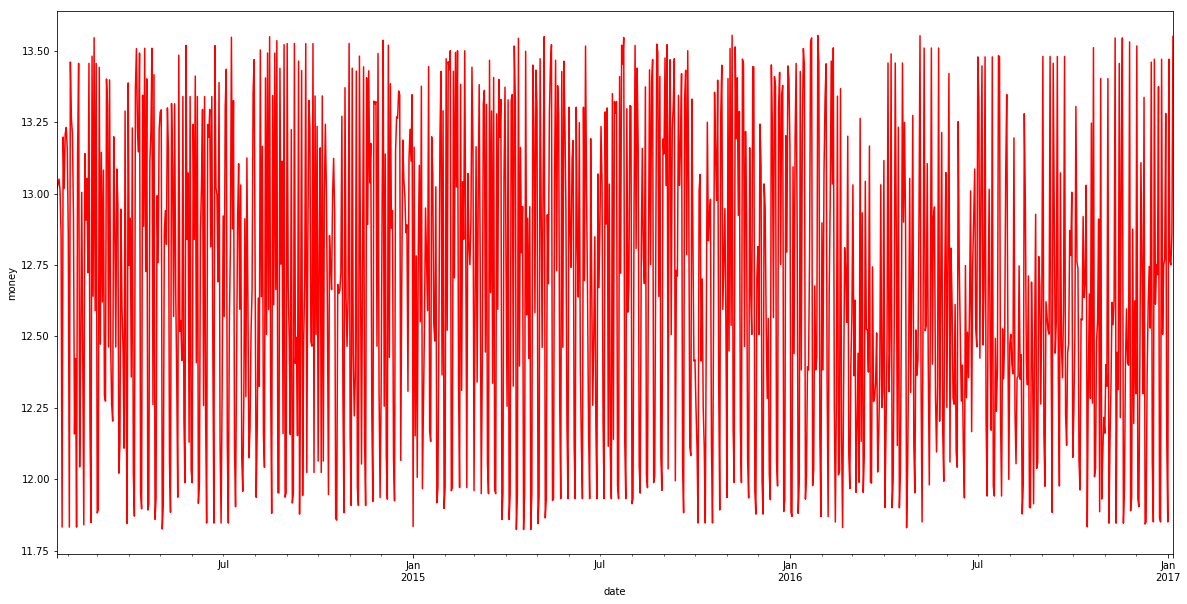

In [8]:
ts = grouped.money
ts_log=np.log(ts)
draw_ts(ts_log)
#平稳检验
'''testStationarity(ts_log)'''
# 划分训练集和测试集
ts_train = ts_log[:'2016-10-31']
ts_test = ts_log['2016-11-01':]

In [9]:
#####对训练集一阶差分
m=7
ts_diff_1 = ts_train.diff(m)
ts_diff_1.dropna(inplace=True)

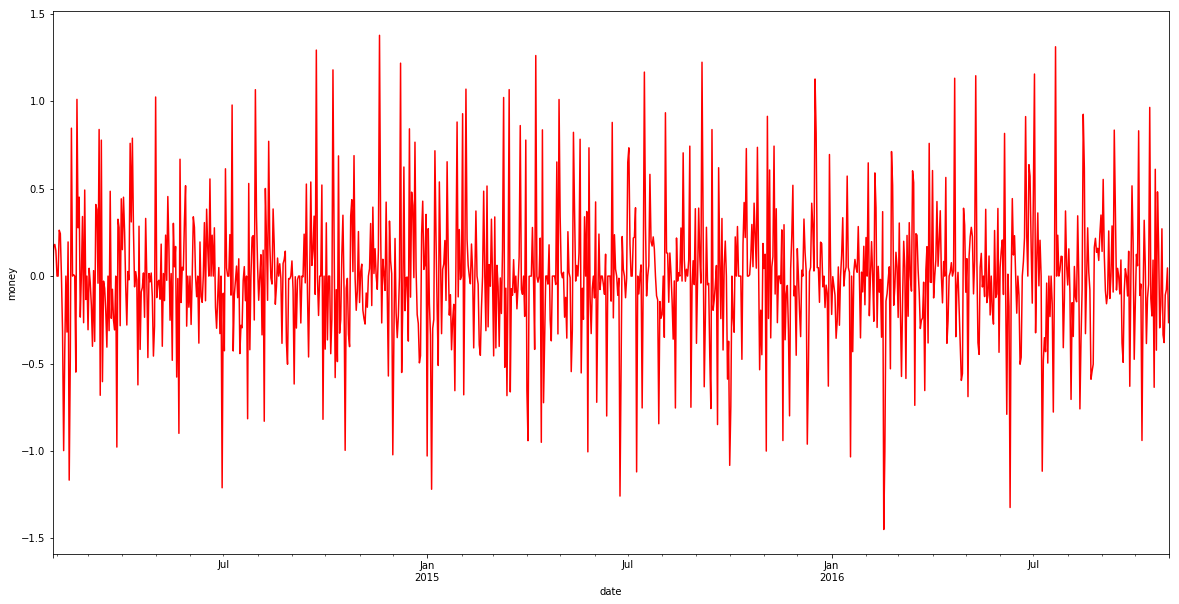

In [10]:
testStationarity(ts_diff_1)
draw_ts(ts_diff_1)

In [11]:
#####寻找平稳时间序列的p，q值
init_bic, init_p, init_q, init_properModel=proper_model(ts_diff_1, 5)

In [12]:
init_p, init_q

(4, 4)

In [13]:
####预测未来n月
n=1

predict_result=[]
   
for i in np.arange(len(ts_test)):
    
    if i*n+(n-1)>=len(ts_test):
        break
    ##根据新加入数据重新拟合模型
    model = ARMA(ts_diff_1, order=(init_p, init_q))
    model_ARMA = model.fit(disp=-1, method='css')
    
    predict_dta = model_ARMA.predict(ts_test.index[i*n].strftime('%Y-%m-%d'),ts_test.index[i*n+(n-1)].strftime('%Y-%m-%d'),dynamic=True)
    ####差分还原
    diff_recover=predict_diff_Index_recover(predict_dta,ts_train,n,m)
    log_recover=diff_recover
    
    ##动态结果
    if i==0:
        predict_result=copy.deepcopy(log_recover)
    else:
        predict_result=pd.concat([predict_result, log_recover])
            
    ####将预测时间的实际值加入到训练样本中
    ts_test_temp=copy.deepcopy(ts_test[i*n:(i*n+n)])
    ts_train=pd.concat([ts_train, ts_test_temp])
    #####差分
    ts_diff_1 = ts_train.diff(m)
    ts_diff_1.dropna(inplace=True)
  

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

In [14]:
predict_result[:5]

2016-11-01    12.670647
2016-11-02    12.771839
2016-11-03    12.032101
2016-11-04    13.175234
2016-11-05    11.821670
dtype: float64

In [15]:
log_recover1 = np.exp(predict_result)
log_recover1.dropna(inplace=True)    
#log_recover1 = predict_result 
original_ts=ts[log_recover1.index]

In [16]:
# 计算误差
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(log_recover1,original_ts))))
print('误差：%.2f%%'%float((error/len(original_ts))*100))

误差：22.98%


In [17]:
# 覆盖率计算，预测值大于真实值
count = 0
for i in range(len(log_recover1)):
    if log_recover1[i] > original_ts[i]:
        count += 1
ratio = count*1.0/len(log_recover1)
print("覆盖率为：%.2f%%"% (ratio*100))

覆盖率为：44.78%


In [18]:
Percentageratio,per = calc_with_err_per(log_recover1,original_ts,0.2)
print('有 %.2f%% 的数据误差在 %.2f%% 之内'% (Percentageratio*100,per*100))

有 61.19% 的数据误差在 20.00% 之内


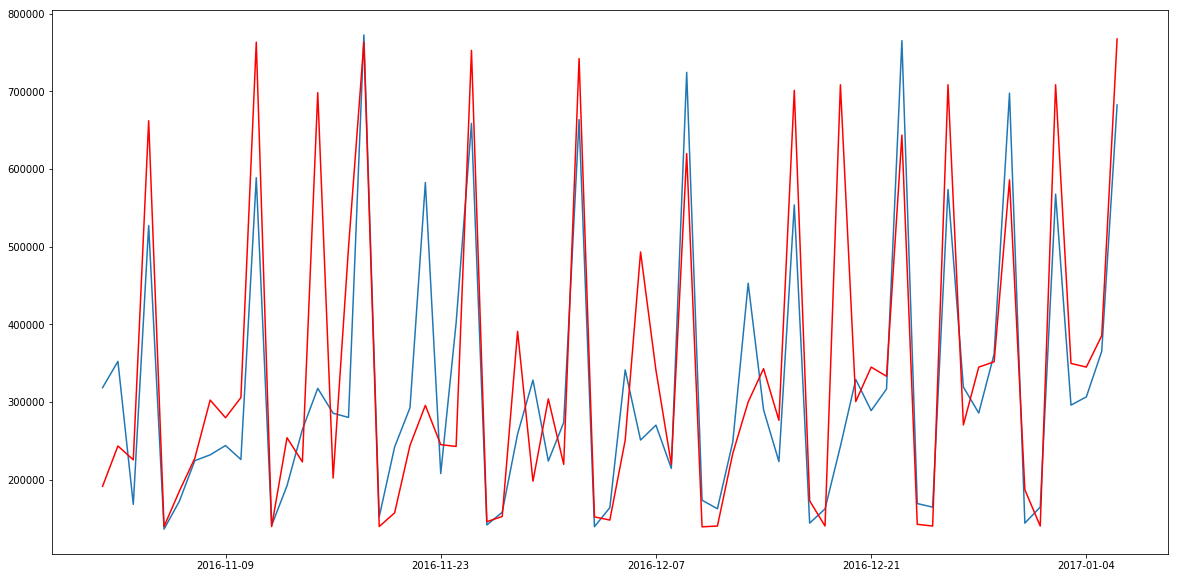

In [19]:
plt.plot(log_recover1[:100])
plt.plot(original_ts[:100], color='red')
plt.show()